# 12S4058 - Pengolahan Data Besar
# Classification using Bank  Marketing Dataset


## Machine Learning with PySpark and MLlib: Solving a Binary Classification Problem

#### Start a session

In [3]:
#import findspark
#findspark.init()
import pyspark
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib.pyplot as plt
%matplotlib inline
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [4]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master("local[2]") \
    .appName("Classification") \
    .getOrCreate()

#### Load External Data: bank-additional-full.csv

In [5]:
df = spark.read.load("bank-additional-full.csv",
                     format="csv", inferSchema="true", header="true")

In [6]:
df.show(5,True)
df.printSchema()

+---+---------+-------+-----------+-------+-------+----+---------+-----+-----------+--------+--------+-----+--------+-----------+------------+--------------+-------------+---------+-----------+---+
|age|      job|marital|  education|default|housing|loan|  contact|month|day_of_week|duration|campaign|pdays|previous|   poutcome|emp.var.rate|cons.price.idx|cons.conf.idx|euribor3m|nr.employed|  y|
+---+---------+-------+-----------+-------+-------+----+---------+-----+-----------+--------+--------+-----+--------+-----------+------------+--------------+-------------+---------+-----------+---+
| 56|housemaid|married|   basic.4y|     no|     no|  no|telephone|  may|        mon|     261|       1|  999|       0|nonexistent|         1.1|        93.994|        -36.4|    4.857|     5191.0| no|
| 57| services|married|high.school|unknown|     no|  no|telephone|  may|        mon|     149|       1|  999|       0|nonexistent|         1.1|        93.994|        -36.4|    4.857|     5191.0| no|
| 37| serv

In [7]:
df.count()

41188

In [8]:
df.describe().show()

+-------+------------------+-------+--------+---------+-------+-------+-----+---------+-----+-----------+-----------------+------------------+------------------+-------------------+--------+------------------+------------------+------------------+------------------+-----------------+-----+
|summary|               age|    job| marital|education|default|housing| loan|  contact|month|day_of_week|         duration|          campaign|             pdays|           previous|poutcome|      emp.var.rate|    cons.price.idx|     cons.conf.idx|         euribor3m|      nr.employed|    y|
+-------+------------------+-------+--------+---------+-------+-------+-----+---------+-----+-----------+-----------------+------------------+------------------+-------------------+--------+------------------+------------------+------------------+------------------+-----------------+-----+
|  count|             41188|  41188|   41188|    41188|  41188|  41188|41188|    41188|41188|      41188|            41188|    

In [9]:
df = df.withColumnRenamed("emp.var.rate","emp_var_rate")
df = df.withColumnRenamed("cons.price.idx","cons_price_idx")
df = df.withColumnRenamed("cons.conf.idx","cons_conf_idx")
df = df.withColumnRenamed("nr.employed","nr_employed")

In [10]:
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day_of_week: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- emp_var_rate: double (nullable = true)
 |-- cons_price_idx: double (nullable = true)
 |-- cons_conf_idx: double (nullable = true)
 |-- euribor3m: double (nullable = true)
 |-- nr_employed: double (nullable = true)
 |-- y: string (nullable = true)



In [11]:
df.toPandas().groupby(['y']).size()

y
no     36548
yes     4640
dtype: int64

In [12]:
numeric_features = [t[0] for t in df.dtypes if t[1] == 'int']
df.select(numeric_features).describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
age,41188,40.02406040594348,10.421249980934057,17,98
duration,41188,258.2850101971448,259.279248836465,0,4918
campaign,41188,2.567592502670681,2.7700135429023245,1,56
pdays,41188,962.4754540157328,186.91090734474085,0,999
previous,41188,0.17296299893172767,0.4949010798392899,0,7


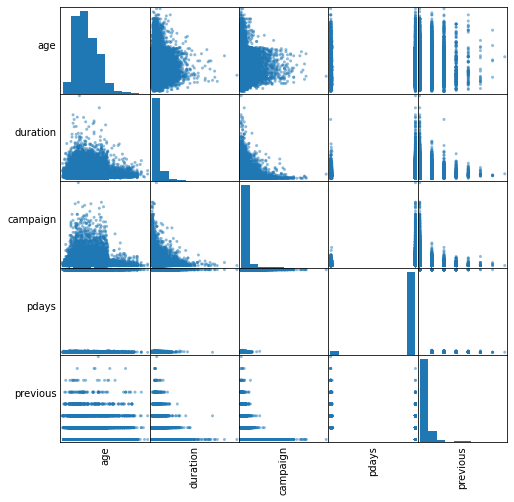

In [13]:
import pandas as pd
numeric_data = df.select(numeric_features).toPandas()
axs = pd.plotting.scatter_matrix(numeric_data, figsize=(8, 8));
n = len(numeric_data.columns)

for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

In [14]:
df = df.select(
    'age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 
    'contact', 'duration', 'campaign', 'pdays', 'poutcome', 'emp_var_rate',
    'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed', 'y'
)
cols = df.columns
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- emp_var_rate: double (nullable = true)
 |-- cons_price_idx: double (nullable = true)
 |-- cons_conf_idx: double (nullable = true)
 |-- euribor3m: double (nullable = true)
 |-- nr_employed: double (nullable = true)
 |-- y: string (nullable = true)



#### Preparing Dataset for Machine Learning

In [15]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler

stages = []
categoricalColumns = [
    'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome'
]

for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoder(
        inputCols=[stringIndexer.getOutputCol()], 
        outputCols=[categoricalCol + "classVec"]
    )
    stages += [stringIndexer, encoder]
    
label_stringIdx = StringIndexer(inputCol = 'y', outputCol = 'label')
stages += [label_stringIdx]
numericCols = ['age', 'duration', 'campaign', 'pdays', 'emp_var_rate', 'cons_price_idx', 
               'cons_conf_idx', 'euribor3m', 'nr_employed']
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [16]:
from pyspark.ml import Pipeline

pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df)
df = pipelineModel.transform(df)
selectedCols = ['label', 'features'] + cols
df = df.select(selectedCols)
df.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- emp_var_rate: double (nullable = true)
 |-- cons_price_idx: double (nullable = true)
 |-- cons_conf_idx: double (nullable = true)
 |-- euribor3m: double (nullable = true)
 |-- nr_employed: double (nullable = true)
 |-- y: string (nullable = true)



In [17]:
pdf = pd.DataFrame(df.take(5), columns=df.columns)
pdf.iloc[:,0:2]

,label,features
0,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ..."
1,0.0,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,0.0,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,0.0,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [19]:
len(pdf.features[0])

39

In [20]:
train, test = df.randomSplit([0.7, 0.3], seed = 2018)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 28839
Test Dataset Count: 12349


## Random Forest Classifier

In [21]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
rfModel = rf.fit(train)
rfPreds = rfModel.transform(test)
rfPreds.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+------+-----+--------------------+----------+--------------------+
|age|   job|label|       rawPrediction|prediction|         probability|
+---+------+-----+--------------------+----------+--------------------+
| 24|admin.|  0.0|[18.9566783931814...|       0.0|[0.94783391965907...|
| 28|admin.|  0.0|[17.8496673378814...|       0.0|[0.89248336689407...|
| 28|admin.|  0.0|[17.4289891574999...|       0.0|[0.87144945787499...|
| 29|admin.|  0.0|[18.9566783931814...|       0.0|[0.94783391965907...|
| 29|admin.|  0.0|[18.9708498615824...|       0.0|[0.94854249307912...|
| 29|admin.|  0.0|[18.9566783931814...|       0.0|[0.94783391965907...|
| 29|admin.|  0.0|[18.9708498615824...|       0.0|[0.94854249307912...|
| 30|admin.|  0.0|[18.9566783931814...|       0.0|[0.94783391965907...|
| 30|admin.|  0.0|[18.9566783931814...|       0.0|[0.94783391965907...|
| 30|admin.|  0.0|[18.8797263598528...|       0.0|[0.94398631799264...|
+---+------+-----+--------------------+----------+--------------

In [23]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
rfEval = BinaryClassificationEvaluator()
rfROC = rfEval.evaluate(rfPreds, {rfEval.metricName: "areaUnderROC"})
print("Test Area Under ROC: " + str(rfROC))

Test Area Under ROC: 0.9183361759870655
